In [1]:
from sklearn.datasets import load_iris
iris_data = load_iris()

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [2]:
features = iris_data.data
labels = iris_data.target

In [3]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

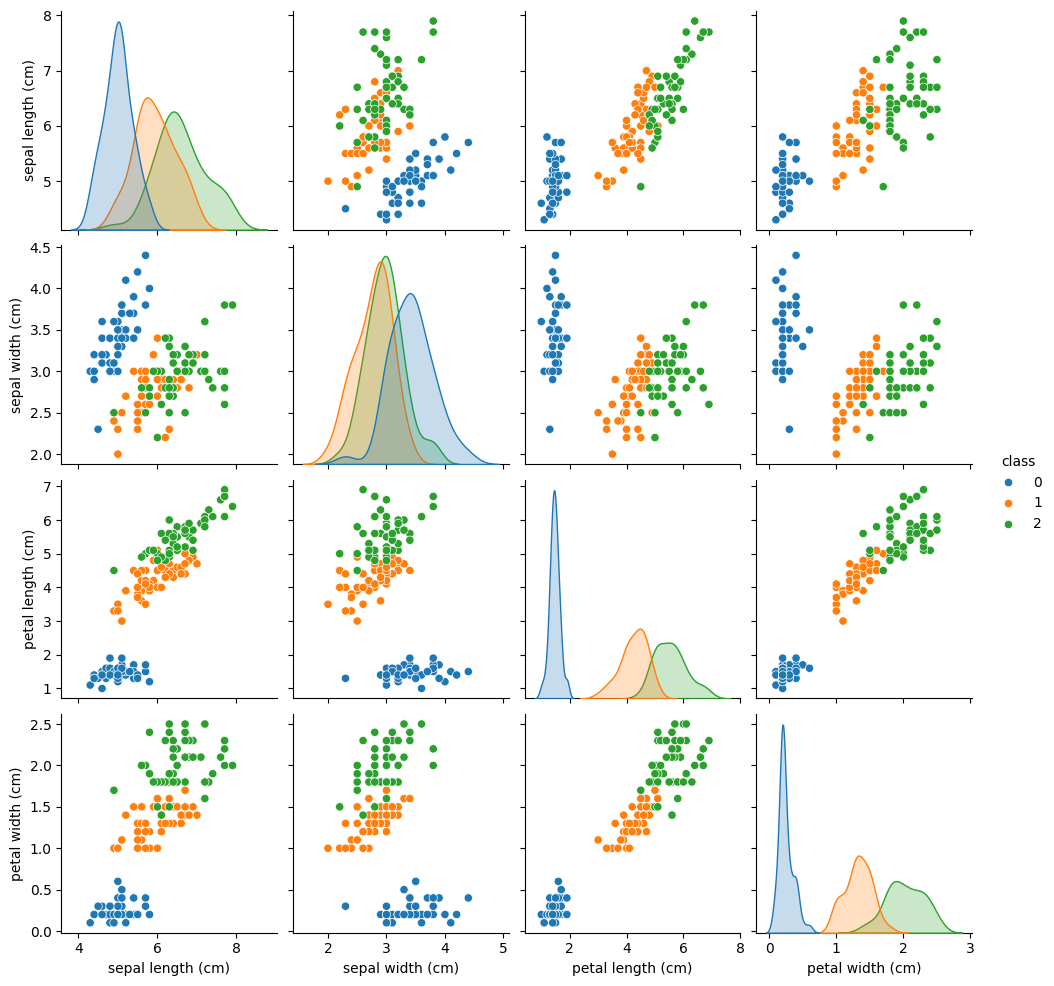

In [4]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

In [5]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

/tmp/ipykernel_972/1930597496.py:4: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  algorithm_globals.random_seed = 123
/tmp/ipykernel_972/1930597496.py:6: DeprecationWarning: The property ``qiskit.utils.algorithm_globals.QiskitAlgorithmGlobals.random_seed`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. This algorithm utility has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. You can run ``pip install qiskit_algorithms`` and import ``from qiskit_algorithms.utils`` instead. 
  features, labels, train_size=0

In [6]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import ParameterVector

def rotation_block(circuit, parameters):
    # assumes nb of params equal to num of qubits
    for i in range(circuit.num_qubits):
        circuit.ry(parameters[i],i)

def non_linear(circuit, param, qubit):
    # the circuit, the parameter and the qubit of interest
    circuit.ry(param, qubit)
    circuit.measure(qubit, 0)
    circuit.ry(-param, qubit)

def myAnsatz(nFeat, reps, nonlin_qubits, barrier=True, final_rotation=True):
    # nFeat number of qubits here
    # nonlin_qubits list of qubits where we want to have non linearity
    nb = len(nonlin_qubits)
    n=nFeat+nb
    # nFeat+nb parameters for each step of the reps, plus nFeat depending on whether we want a final rotation layer or not
    if final_rotation:
        params=(n)*reps+nFeat
    else:
        params=(n)*reps
    beta = ParameterVector('beta', length=params)
    qubits = QuantumRegister(nFeat,'q')
    # bit 0 will be the trash we don't care about, all the other will have the significant measures
    meas = ClassicalRegister(nFeat+1,'meas')
    test = QuantumCircuit(qubits, meas)

    #we'll look at the parameters mod n, the first nFeat
    for p in range(reps):
        #rotation block, looking at the nFeat parameters first
        rotation_block(test, beta[n*p:n*p+nFeat])
        if barrier: test.barrier()
        
        #entanglement block, here linear but can easily be changed depending on what you want to test by changing the cx connexions
        test.cx(range(nFeat-2,-1,-1), range(nFeat-1,0,-1))
        if barrier: test.barrier()
    
        # non-linear part, we'll check the last nb of parameters mod n 
        for k,qubit in enumerate(nonlin_qubits):
            par=n*p+nFeat+k
            non_linear(test, beta[par],qubit)
        if barrier: test.barrier()
        
    #final rotation block, optional
    if final_rotation: 
        rotation_block(test,beta[params-nFeat:params])
        if barrier: test.barrier()
    test.measure(range(nFeat),meas[1:])
    return test, qubits, meas

In [7]:
nFeat = features.shape[1]
reps = 1
ansatz_circ = myAnsatz(nFeat, 1, [0,2])[0]

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


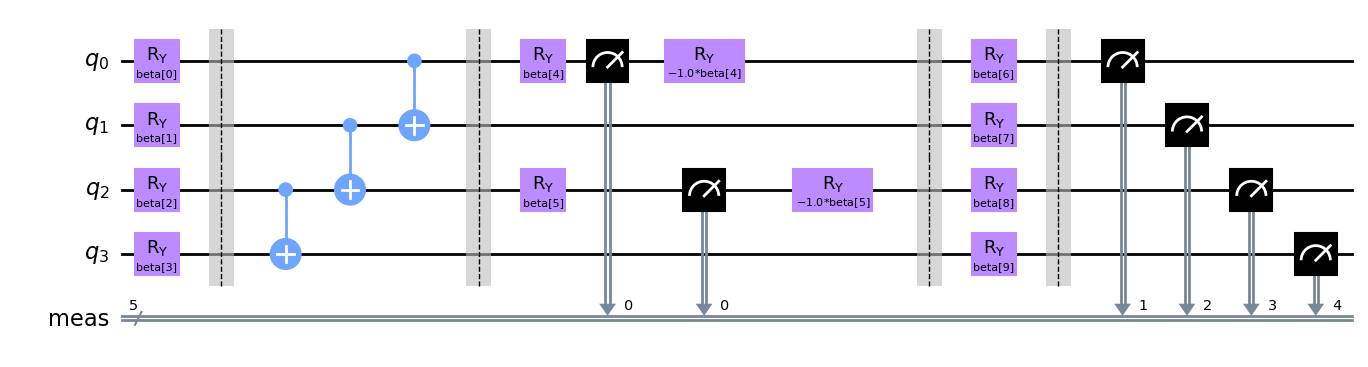

In [8]:
#construct the ansatz circuit
ansatz_circ.draw(output = 'mpl')

/usr/local/lib/python3.10/dist-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


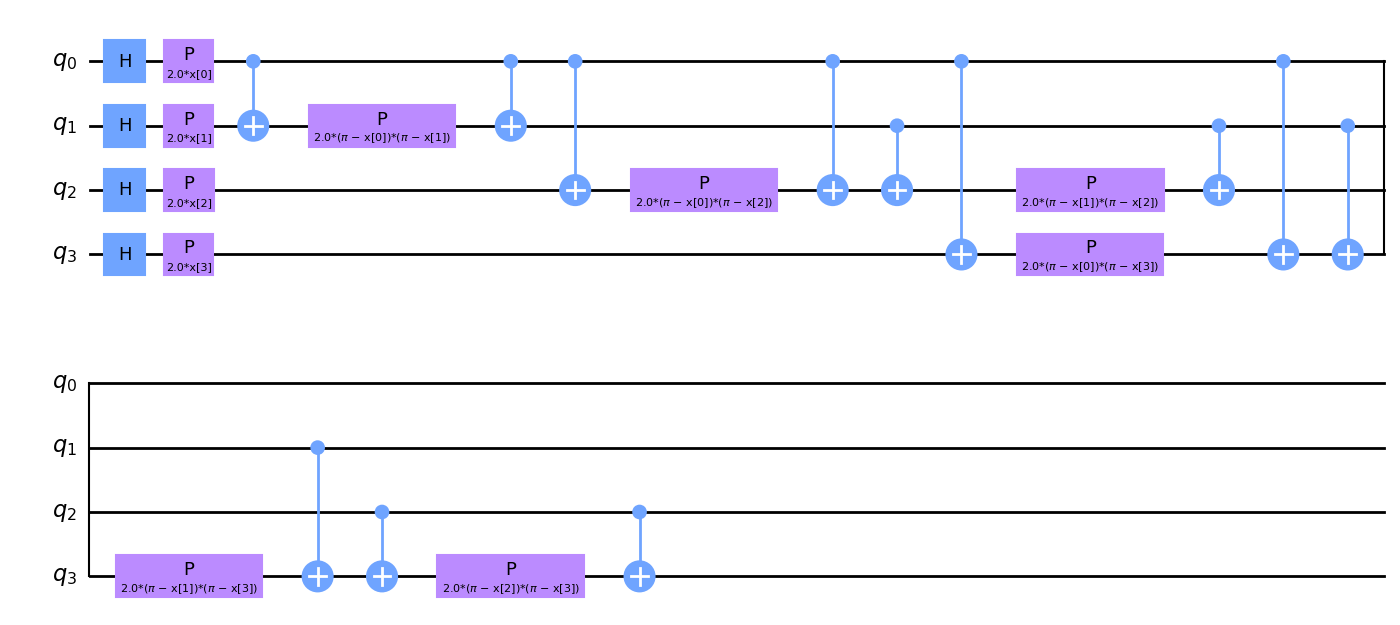

In [9]:
#construct the feature map
from qiskit.circuit.library import ZZFeatureMap
feature_map = ZZFeatureMap(feature_dimension=nFeat, reps=1)
feature_map.decompose().draw(output="mpl", fold=20)

In [10]:
from qiskit.algorithms.optimizers import COBYLA
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session

/tmp/ipykernel_972/2367804263.py:1: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA
OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [11]:
#load the service
service = QiskitRuntimeService(channel = 'ibm_quantum')

In [12]:
backend = service.get_backend('ibmq_qasm_simulator') # change this for a real execution

In [13]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## VQC

In [15]:
# create the program for samplig results on a backend
options = Options()
options.resilience_level = 0
options.execution.shots =1024
session = Session(backend=backend)
sampler = Sampler(session=session, options=options)
#sampler = Sampler(backend, options) #if you do not want to use sessions

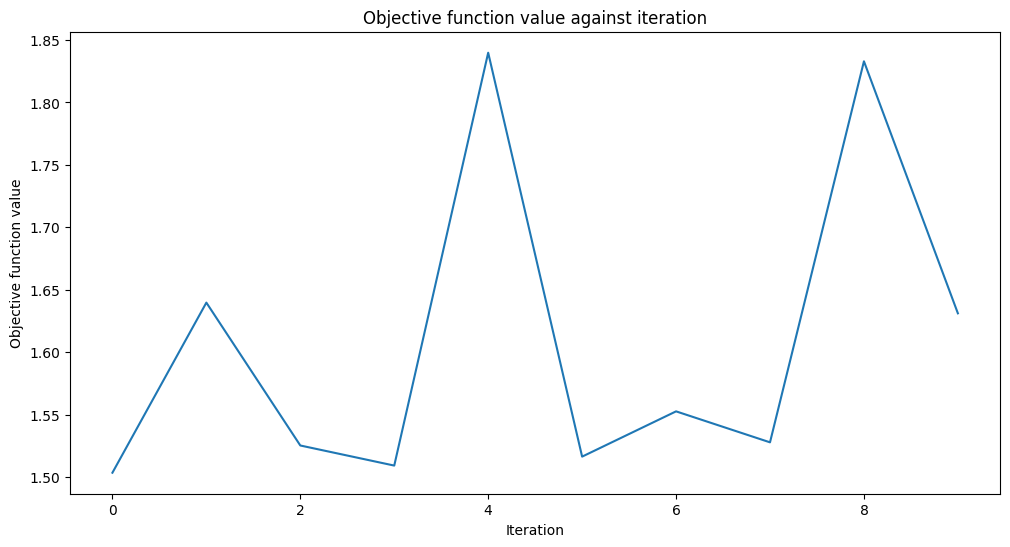

Training time: 240 seconds


In [16]:
# with vqc all the measurements bitstrings are taken into account
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

# optimizer
optimizer = COBYLA(maxiter=20)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz_circ,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

#close your session
session.close()

## SamplerQNN

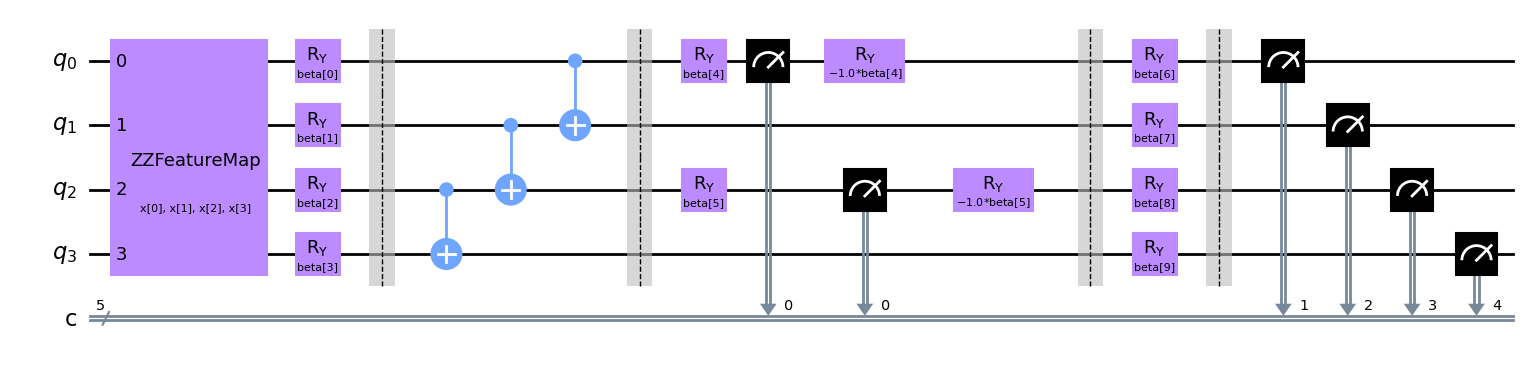

In [18]:
# construct quantum circuit
num_cregs = len(ansatz_circ.clbits) # number of classical registers in the ansatz
circuit = QuantumCircuit(nFeat,num_cregs)
circuit.append(feature_map, range(nFeat))
circuit.append(ansatz_circ, range(nFeat),range(num_cregs))
circuit.decompose().draw(output="mpl")

In [19]:
# parity maps bitstrings to 0 or 1
''' Since the first two mid circuits measurements are on the classical bit 0, we will take only the 4 last classical
 bits to map to the labels, please feel free to choose which bits you want to map.
'''
def parity(x):
    bitstrings = format(x,'0'+str(num_cregs) + 'b') # convert the quasi probabilities to the
    return bitstrings[0:4].count("1") % 2 # only take the 4 last measurements [0:4]


In [20]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN

In [26]:
# construct QNN

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.
options = Options()
options.resilience_level = 0
options.execution.shots =1024
session = Session(backend=backend)
sampler = Sampler(session=session, options=options)
#sampler = Sampler(backend, options) #if you do not want to use sessions
optimizer = COBYLA(maxiter=20)

sampler_qnn = SamplerQNN(
    circuit=circuit.decompose(), #we decompose the circuit because samplerqnn will check if the measurements are present in the circuit
    input_params=feature_map.parameters,
    weight_params=ansatz_circ.parameters,
    interpret=parity, #put the parity function here to select specific bitstrings.
    output_shape=output_shape,
    sampler=sampler
)


In [27]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=optimizer, callback=callback_graph
)

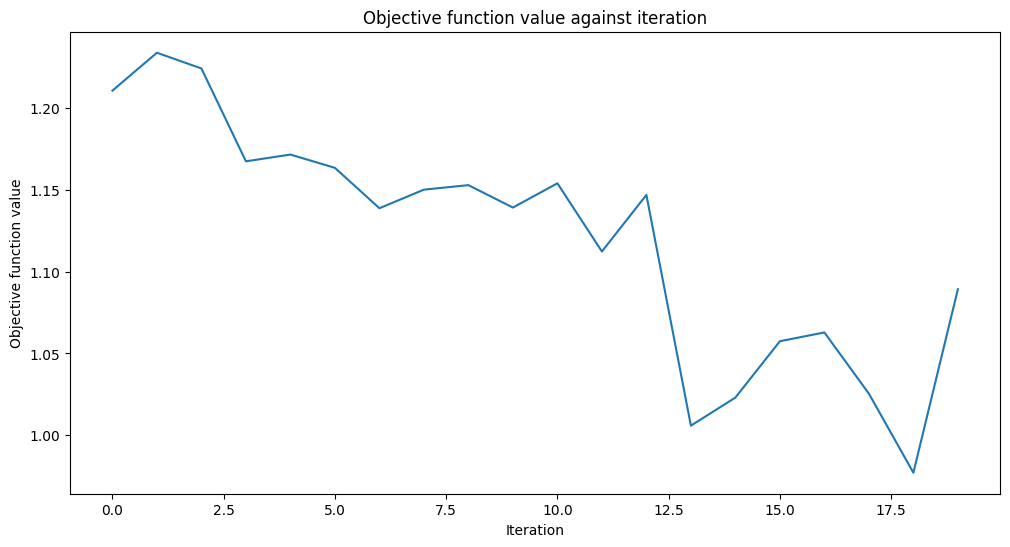

0.36666666666666664


In [28]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(train_features, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print(sampler_classifier.score(train_features, train_labels))

#close your session
session.close()